# Flatiron Phase 4 Project

* <b>Name:</b> James Benedito
* <b>Pace:</b> Part-Time
* <b>Instructor:</b> Morgan Jones

# Business Problem

When it comes to business in general, it is important to make informed decisions on where to invest funds because a high ROI is imperative for a company to thrive. Data is a powerful tool that can be leveraged to determine where huge profits can potentially be gained.

This Jupyter notebook will examine data to highlight the Top 5 zipcodes in Nevada to invest in. The information presented will be applicable to real estate companies in Nevada state who are seeking out the best locations for their clients.

# Goal

My goal is to use time series data from Zillow to generate recommendations for a theoretical real estate company in Nevada, in terms of which zipcodes would be best to invest in. My suggestions will be informed by an optimized ARIMA model. I will use ROI as my main metric of interest.

# Dataset 

The data used for this project comes from Zillow and is stored in a file called <b>zillow_data.csv</b>. The dataset shows housing prices over time, with each row representing a specific zipcode in a particular US city. As mentioned previously, I will be focusing on merely a subset of this data. The dataframe will be filtered so that it only includes houses located in Nevada. 

# Data Exploration and Preprocessing

To start, I will explore the Zillow dataset to see how it is set up. From <b>.head()</b>, we see that the dataset has <b>272 columns</b>. Most of these columns represent dates in time and house the median price of houses in a particular zipcode. The other columns include <b>RegionID</b>, <b>RegionName</b>, <b>City</b>, <b>State</b>, <b>Metro</b>, <b>CountyName</b>, and <b>SizeRank</b>. We see that the data is quite expansive, encompassing information from many different cities and counties across the United States. As mentioned earlier, I want to filter the data so that it focuses merely on zipcodes in <b>Nevada</b> state because that is where the theoretical real estate company is based. From the main dataframe <b>zillow_df</b>, I will create a subset called <b>nv_df</b> that only has data on Nevada zipcodes. 

In [1]:
# import necessary packages
import warnings
import itertools
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
from matplotlib.pylab import rcParams

In [2]:
# read dataset into pandas df
zillow_df = pd.read_csv('zillow_data.csv')
zillow_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [8]:
# filter dataset so it only includes zipcodes in Nevada 
nv_df = zillow_df[zillow_df['State']=='NV']
nv_df

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
115,95804,89108,Las Vegas,NV,Las Vegas,Clark,116,102500.0,102500.0,102500.0,...,180400,183300,186600,190200,193400,197300,200700,203500,206600,209300
173,95817,89121,Las Vegas,NV,Las Vegas,Clark,174,106800.0,107000.0,107200.0,...,183200,185500,188600,192500,195500,198700,201500,204000,206700,208600
195,95813,89117,Las Vegas,NV,Las Vegas,Clark,196,165100.0,164500.0,164000.0,...,310300,312600,315600,320000,323500,327100,330700,334600,338800,342000
262,95785,89052,Henderson,NV,Las Vegas,Clark,263,185700.0,186300.0,186900.0,...,384400,387000,391000,396100,399900,403800,407300,410400,413700,416100
309,95819,89123,Las Vegas,NV,Las Vegas,Clark,310,144000.0,143500.0,143100.0,...,273000,275600,278900,283000,286500,290400,294300,297400,300200,302400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14081,95891,89411,Genoa,NV,Gardnerville Ranchos,Douglas,14082,299200.0,299600.0,299900.0,...,635600,635200,637900,642200,641100,639300,642500,653800,666000,672600
14328,95820,89124,Mount Charleston,NV,Las Vegas,Clark,14329,166100.0,166600.0,167300.0,...,316100,315500,316200,319500,318400,316800,317600,323400,334700,344300
14381,95917,89440,Dayton,NV,Fernley,Lyon,14382,NaN,NaN,NaN,...,190300,193500,196700,197900,198200,199800,201600,207000,216500,222800
14711,95893,89413,Glenbrook,NV,Gardnerville Ranchos,Douglas,14712,562400.0,562800.0,562700.0,...,2094700,2093300,2097700,2098400,2093600,2098400,2121300,2153600,2167100,2161900


Now that I have the filtered dataset, <b>nv_df</b>, I will explore the data further by looking at the <b>county</b> that has the most zipcodes. Using <b>.value_counts()</b>, I see that <b>Clark County</b> has the most zipcodes by far. I will therefore create another dataframe, <b>clark_df</b>, that focuses on the <b>61 zipcodes</b> in Clark County. I will also make a bar chart that shows the Clark County zipcodes by city. From the bar graph below, we see that <b>Las Vegas</b> is the city where most of the zipcodes are located in, accounting for <b>38 zipcodes</b> out of the 61 Clark County zipcodes.

In [10]:
nv_df['CountyName'].value_counts()

Clark          61
Washoe         19
Douglas         8
Lyon            5
Carson City     5
Nye             3
Elko            2
Name: CountyName, dtype: int64

In [11]:
clark_df = nv_df[nv_df['CountyName']=='Clark']
clark_df

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
115,95804,89108,Las Vegas,NV,Las Vegas,Clark,116,102500.0,102500.0,102500.0,...,180400,183300,186600,190200,193400,197300,200700,203500,206600,209300
173,95817,89121,Las Vegas,NV,Las Vegas,Clark,174,106800.0,107000.0,107200.0,...,183200,185500,188600,192500,195500,198700,201500,204000,206700,208600
195,95813,89117,Las Vegas,NV,Las Vegas,Clark,196,165100.0,164500.0,164000.0,...,310300,312600,315600,320000,323500,327100,330700,334600,338800,342000
262,95785,89052,Henderson,NV,Las Vegas,Clark,263,185700.0,186300.0,186900.0,...,384400,387000,391000,396100,399900,403800,407300,410400,413700,416100
309,95819,89123,Las Vegas,NV,Las Vegas,Clark,310,144000.0,143500.0,143100.0,...,273000,275600,278900,283000,286500,290400,294300,297400,300200,302400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12364,95794,89085,North Las Vegas,NV,Las Vegas,Clark,12365,170900.0,170800.0,170700.0,...,298900,301000,303200,306700,309700,313100,316500,319500,322400,324700
12407,399666,89034,Mesquite,NV,Las Vegas,Clark,12408,196000.0,196000.0,195900.0,...,289400,294500,299800,304700,308100,311700,315500,319500,323600,326600
13020,95760,89021,Logandale,NV,Las Vegas,Clark,13021,153200.0,153700.0,154100.0,...,288500,290000,292500,295500,297100,298300,299900,302500,305700,307800
14328,95820,89124,Mount Charleston,NV,Las Vegas,Clark,14329,166100.0,166600.0,167300.0,...,316100,315500,316200,319500,318400,316800,317600,323400,334700,344300


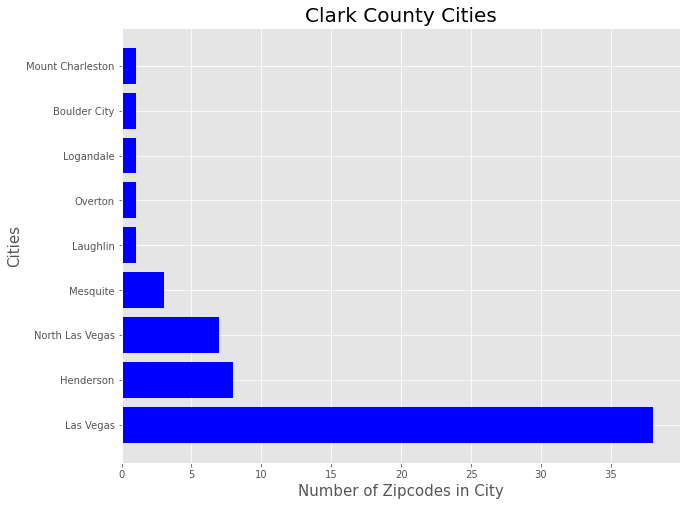

In [15]:
# Code adapted from Sanjit Varma 
# Source: https://github.com/sanjitva/Zillow-TimeSeries-Modeling/blob/main/final_notebook.ipynb

# Clark County zipcodes by city

fig, ax = plt.subplots(figsize=(10,8))
x = [a for a in clark_df['City'].value_counts().keys()]
y = [a for a in clark_df['City'].value_counts()]

ax.barh(x, y, color='blue')
ax.set_title('Clark County Cities', fontsize=20)
ax.set_xlabel('Number of Zipcodes in City', fontsize=15)
ax.set_ylabel('Cities', fontsize=15);

One important thing that must be done to the <b>clark_df</b> is to melt it. The dataframe right now is in wide form and must be converted to long form. The function <b>melt_data()</b> can be used to achieve this melting of <b>clark_df</b>.  

In [16]:
# melt_data function provided in starter notebook
# converts from wide-form to long-form

def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [17]:
melt_data(clark_df)

,value
time,
1996-04-01,140188.135593
1996-05-01,140054.237288
1996-06-01,139923.728814
1996-07-01,139810.169492
1996-08-01,139742.372881
...,...
2017-12-01,268295.081967
2018-01-01,271267.213115
2018-02-01,274286.885246


# Step 5: ARIMA Modeling

# Step 6: Interpreting Results